In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.lines
import statsmodels.api as sm
import scipy.stats
import scipy.optimize
import scipy.interpolate
import scipy.integrate
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.neighbors
import seaborn
import collections

## MPO Extrapolation

In [2]:
C0, C1, C2, C3, C4 = matplotlib.colors.to_rgb('C0'), matplotlib.colors.to_rgb('C1'), matplotlib.colors.to_rgb('C2'), matplotlib.colors.to_rgb('C3'), matplotlib.colors.to_rgb('C4')
def dark(c):
    return (c[0]*0.8, c[1]*0.8, c[2]*0.8)

In [3]:
mpo_data = np.load("processed/mpo_props.npz")

In [4]:
mpo_X = np.stack([
    mpo_data['crossings'],
    mpo_data['depths'],
    mpo_data['qubits']
], axis=-1)

In [5]:
thresh = 200

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(mpo_X[mpo_X[:,0] > thresh])
mpo_X_standardized = scaler.transform(mpo_X)

In [6]:
decomp = sklearn.decomposition.PCA()
decomp.fit(mpo_X_standardized[mpo_X[:,0] > thresh])
mpo_X_comps = decomp.transform(mpo_X_standardized)

In [ ]:
fit_flops = sm.OLS(np.log10(mpo_data['flops'][:, -1][mpo_X[:,0] > thresh]), sm.add_constant(mpo_X_comps[mpo_X[:,0] > thresh])).fit()
fit_flops.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1871.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        05:52:25   Log-Likelihood:                -5249.4
No. Observations:                5261   AIC:                         1.051e+04
Df Residuals:                    5257   BIC:                         1.053e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4879      0.009   1048.178      0.000       9.470       9.506
x1             0.4615      0.007     68.924      0.000       0.448       0.475
x2            -0.1944      0.008    -23.039      0.000      -0.211      -0.178
x3             1.1118      0.061     18.197      0.000       0.992       1.232
==============================================================================
Omnibus:                      339.674   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              455.033
Skew:                           0.582   Prob(JB):                     1.55e-99
Kurtosis:                       3.850   Cond. No.                         9.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
preds = fit_flops.get_prediction(sm.add_constant(mpo_X_comps)).summary_frame()

In [9]:
factor = 15.0
extra_X = scaler.inverse_transform(decomp.inverse_transform(np.stack([
    factor * np.linspace(mpo_X_comps[:, 0].min(), mpo_X_comps[:, 0].max(), 1000),
    np.zeros(1000),
    np.zeros(1000)
], axis=-1).reshape(-1, 3)))
extra_X = extra_X[(extra_X[..., 0] >= 0) & (extra_X[..., 1] >= 0) & (extra_X[..., 2] >= 0)]
extra_X_comps = decomp.transform(scaler.transform(extra_X))
extra_preds = fit_flops.get_prediction(sm.add_constant(extra_X_comps)).summary_frame(alpha=0.05)

In [10]:
fit_mem = sm.OLS(np.log10(mpo_data['max_intermediate'])[mpo_X[:,0] > thresh], sm.add_constant(mpo_X_comps[mpo_X[:,0] > thresh])).fit()
fit_mem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1581.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        05:52:27   Log-Likelihood:                -3417.5
No. Observations:                5261   AIC:                             6843.
Df Residuals:                    5257   BIC:                             6869.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0717      0.006    793.682      0.000       5.059       5.084
x1             0.3073      0.005     65.022      0.000       0.298       0.317
x2            -0.0858      0.006    -14.401      0.000      -0.097      -0.074
x3             0.7580      0.043     17.573      0.000       0.673       0.843
==============================================================================
Omnibus:                      301.432   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.309
Skew:                           0.541   Prob(JB):                     8.76e-87
Kurtosis:                       3.799   Cond. No.                         9.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
preds_mem = fit_mem.get_prediction(sm.add_constant(mpo_X_comps)).summary_frame()
extra_preds_mem = fit_mem.get_prediction(sm.add_constant(extra_X_comps)).summary_frame(alpha=0.05)

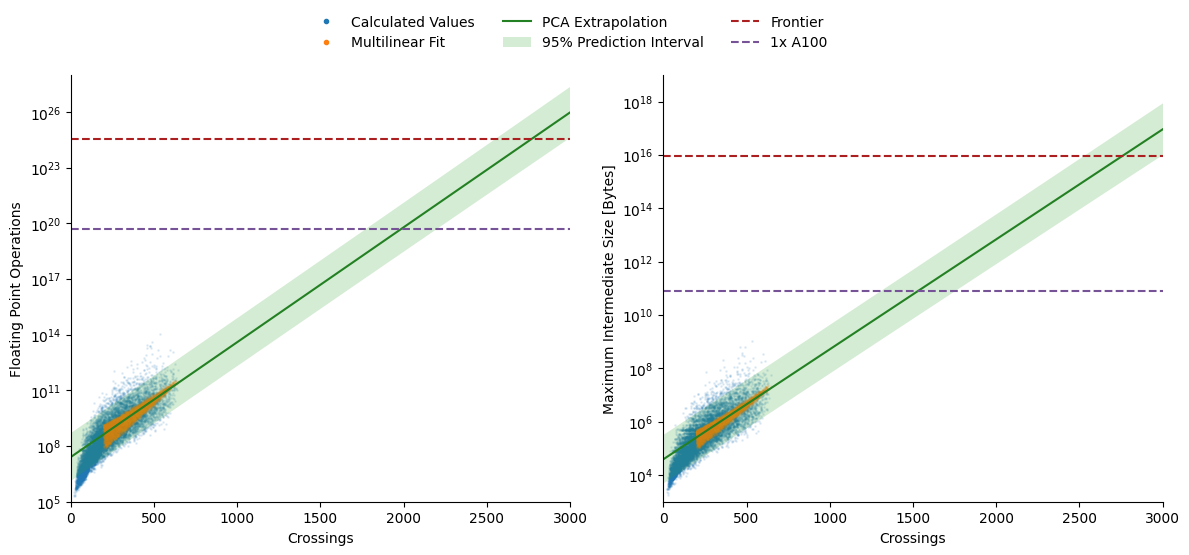

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(mpo_X[:, 0], mpo_data['flops'][:, -1], s=1, alpha=0.1, c='C0', rasterized=True)
ax1.scatter(mpo_X[:, 0][mpo_X[:,0] > thresh], 10**preds['mean'][mpo_X[:,0] > thresh], s=1, alpha=0.1, c='C1', rasterized=True)
ax1.plot(extra_X[:, 0], 10**extra_preds['mean'], '-', color=dark(C2))
ax1.fill_between(extra_X[:, 0], 10**extra_preds['obs_ci_lower'], 10**extra_preds['obs_ci_upper'], alpha=0.2, facecolor='C2')
ax1.axhline(1.353e18 * 3600 * 24 * 30, color=dark(C3), linestyle='--')
ax1.axhline(19.5e12 * 3600 * 24 * 30, color=dark(C4), linestyle='--')
ax1.set_yscale('log')
ax1.set_xlim(extra_X[:, 0].min(), 3000)
ax1.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000]);
ax1.set_ylabel("Floating Point Operations")
ax1.set_xlabel("Crossings")
ax2.scatter(mpo_X[:, 0], 8*mpo_data['max_intermediate'], s=1, alpha=0.1, c='C0', rasterized=True)
ax2.scatter(mpo_X[:, 0][mpo_X[:,0] > thresh], 8*10**preds_mem['mean'][mpo_X[:,0] > thresh], s=1, alpha=0.1, c='C1', rasterized=True)
ax2.plot(extra_X[:, 0], 8*10**extra_preds_mem['mean'], '-', color=dark(C2))
ax2.fill_between(extra_X[:, 0], 8*10**extra_preds_mem['obs_ci_lower'], 8*10**extra_preds_mem['obs_ci_upper'], alpha=0.2, facecolor='C2')
ax2.axhline(9.2e15, color=dark(C3), linestyle='--')
ax2.axhline(80e9, color=dark(C4), linestyle='--')
ax2.set_yscale('log')
ax2.set_xlim(extra_X[:, 0].min(), 3000)
ax2.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000]);
ax2.set_xlabel("Crossings")
ax2.set_ylabel("Maximum Intermediate Size [Bytes]")
ax1.set_ylim(10**5, 10.0**28)
ax2.set_ylim(10**3, 10**19)
fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], marker='.', color='C1', label='Multilinear Fit', linestyle=''),
    matplotlib.lines.Line2D([], [], color=dark(C2), label='PCA Extrapolation'),
    matplotlib.patches.Patch(facecolor='C2', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.lines.Line2D([], [], color=dark(C3), linestyle='--', label='Frontier'),
    matplotlib.lines.Line2D([], [], color=dark(C4), linestyle='--', label='1x A100')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(1.0, 1.17))
seaborn.despine()
# seaborn.move_legend(plt.gca(), 'upper center', frameon=True, ncols=3, bbox_to_anchor=(0.5, 1.17))

plt.savefig("output/mpo_extrapolation_flops.svg", dpi=200, bbox_inches='tight')

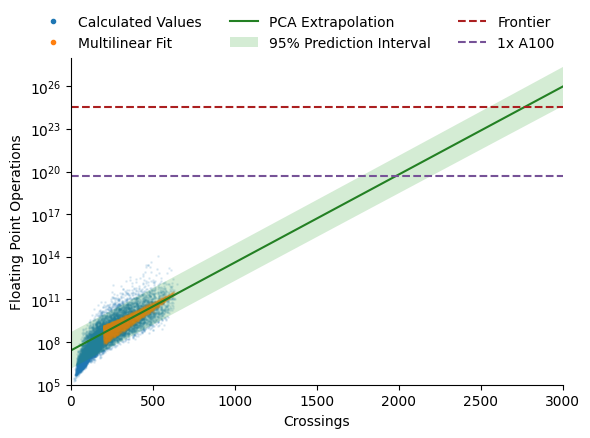

In [14]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6.0, 4))

ax1.scatter(mpo_X[:, 0], mpo_data['flops'][:, -1], s=1, alpha=0.1, c='C0', rasterized=True)
ax1.scatter(mpo_X[:, 0][mpo_X[:,0] > thresh], 10**preds['mean'][mpo_X[:,0] > thresh], s=1, alpha=0.1, c='C1', rasterized=True)
ax1.plot(extra_X[:, 0], 10**extra_preds['mean'], '-', color=dark(C2))
ax1.fill_between(extra_X[:, 0], 10**extra_preds['obs_ci_lower'], 10**extra_preds['obs_ci_upper'], alpha=0.2, facecolor='C2')
ax1.axhline(1.353e18 * 3600 * 24 * 30, color=dark(C3), linestyle='--')
ax1.axhline(19.5e12 * 3600 * 24 * 30, color=dark(C4), linestyle='--')
ax1.set_yscale('log')
ax1.set_xlim(extra_X[:, 0].min(), 3000)
ax1.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000]);
ax1.set_ylabel("Floating Point Operations")
ax1.set_xlabel("Crossings")
# ax2.scatter(mpo_X[:, 0], 8*mpo_data['max_intermediate'], s=1, alpha=0.1, c='C0', rasterized=True)
# ax2.scatter(mpo_X[:, 0][mpo_X[:,0] > thresh], 8*10**preds_mem['mean'][mpo_X[:,0] > thresh], s=1, alpha=0.1, c='C1', rasterized=True)
# ax2.plot(extra_X[:, 0], 8*10**extra_preds_mem['mean'], '-', color=dark(C2))
# ax2.fill_between(extra_X[:, 0], 8*10**extra_preds_mem['obs_ci_lower'], 8*10**extra_preds_mem['obs_ci_upper'], alpha=0.2, facecolor='C2')
# ax2.axhline(9.2e15, color=dark(C3), linestyle='--')
# ax2.axhline(80e9, color=dark(C4), linestyle='--')
# ax2.set_yscale('log')
# ax2.set_xlim(extra_X[:, 0].min(), 3000)
# ax2.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000]);
# ax2.set_xlabel("Crossings")
# ax2.set_ylabel("Maximum Intermediate Size [Bytes]")
ax1.set_ylim(10**5, 10.0**28)
# ax2.set_ylim(10**3, 10**19)
fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], marker='.', color='C1', label='Multilinear Fit', linestyle=''),
    matplotlib.lines.Line2D([], [], color=dark(C2), label='PCA Extrapolation'),
    matplotlib.patches.Patch(facecolor='C2', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.lines.Line2D([], [], color=dark(C3), linestyle='--', label='Frontier'),
    matplotlib.lines.Line2D([], [], color=dark(C4), linestyle='--', label='1x A100')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.46, 1.17))
seaborn.despine()
# seaborn.move_legend(plt.gca(), 'upper center', frameon=True, ncols=3, bbox_to_anchor=(0.5, 1.17))

plt.savefig("output/mpo_extrapolation_flops.svg", dpi=200, bbox_inches='tight')

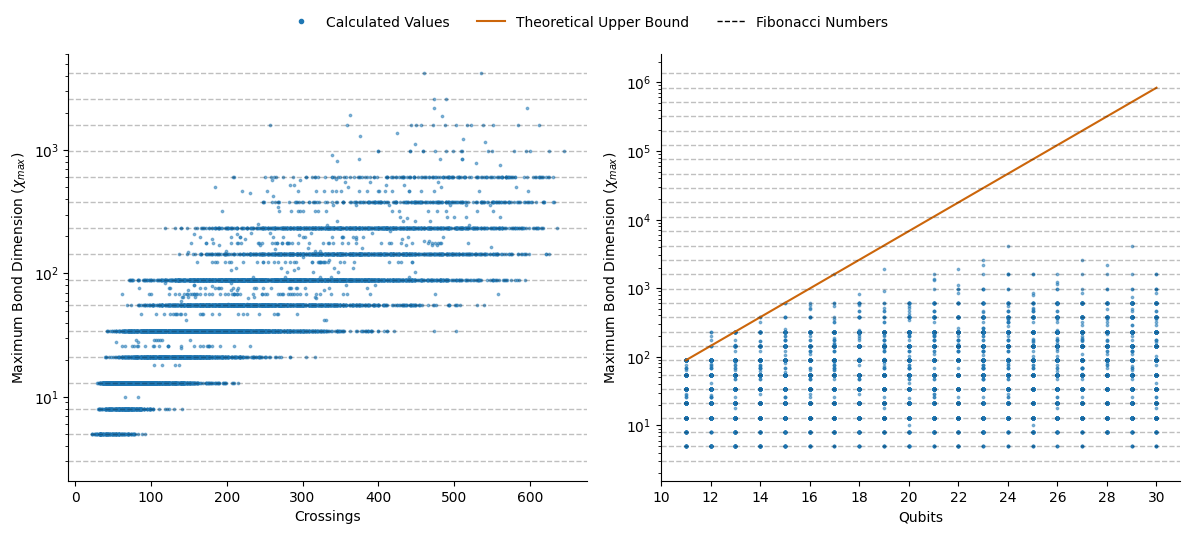

In [16]:
def fib(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(mpo_data['crossings'], mpo_data['max_chi'], s=3, color=C0, alpha=0.5, rasterized=True)

ax2.plot(np.arange(11, 31), [fib(i) for i in np.arange(11, 31)], color=dark(C1))
ax2.scatter(mpo_data['qubits'], mpo_data['max_chi'], s=3, color=C0, alpha=0.5, rasterized=True)

for i in range(4, 20):
    ax1.axhline(fib(i), linestyle='--', color='k', alpha=0.25, linewidth=1.0)

for i in range(4, 32):
    ax2.axhline(fib(i), linestyle='--', color='k', alpha=0.25, linewidth=1.0)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_xticks(np.arange(10, 31, 2))
ax1.set_xlabel('Crossings')
ax2.set_xlabel('Qubits')
ax1.set_ylabel('Maximum Bond Dimension ($\\chi_{max}$)')
ax2.set_ylabel('Maximum Bond Dimension ($\\chi_{max}$)')
fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], marker='', color=dark(C1), label='Theoretical Upper Bound', linestyle='-'),
    matplotlib.lines.Line2D([], [], color='k', linestyle='--', linewidth=1.0, label='Fibonacci Numbers')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(1.0, 1.12))

seaborn.despine()
plt.savefig("output/mpo_maxchi.svg", dpi=200, bbox_inches='tight')

In [17]:
np.mean([any(chi == fib(i) for i in range(4, 21)) for chi in mpo_data['max_chi']])

0.9603

In [18]:
import pickle, tqdm
orig_braids = pickle.load(open("raw_data/mpo_data_d0.pkl", "rb"))
orig_braids2 = pickle.load(open("raw_data/braids_n10_29_l5_50_c50_d8_1024.pkl", "rb"))
braids = [
    {**a, **b} for a, b in zip(orig_braids, orig_braids2)
]
intermediates = [
    np.array([
        4 * (cs[0] + cs[-1] + sum(cs[i] * cs[i + 1] for i in range(len(cs) - 1)))
        for cs in b['mpo-0']['bond_sizes']
    ])
    for b in tqdm.tqdm(braids)
]
maxchis = [np.array([max(s) for s in b['mpo-0']['bond_sizes']]) for b in tqdm.tqdm(braids)]

100%|██████████| 10000/10000 [00:01<00:00, 6823.78it/s]


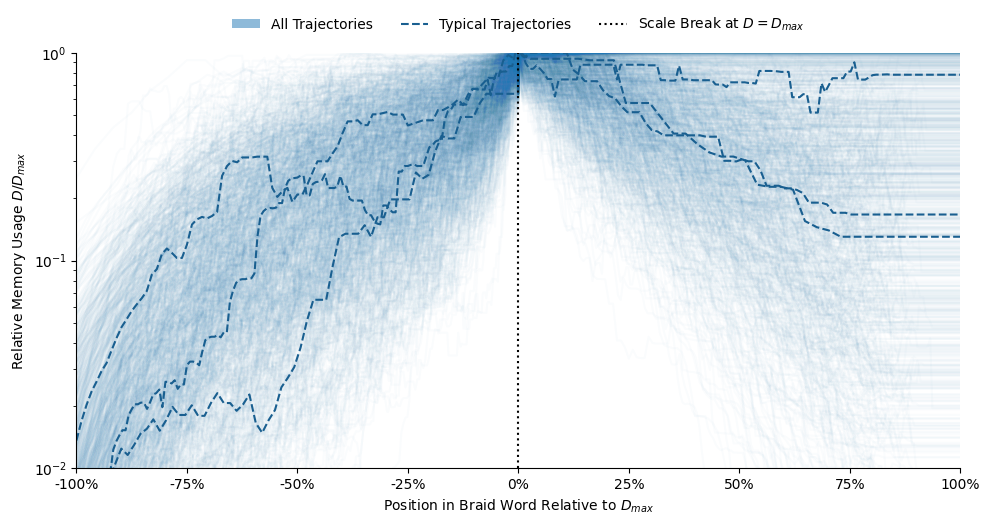

In [19]:
plt.figure(figsize=(10,5))
for i in range(0, 10000, 10):
    xcoords = np.concatenate([
        np.linspace(-1, 0, np.argmax(intermediates[i])),
        np.linspace(0, 1, len(intermediates[i]) - np.argmax(intermediates[i]))
    ])#np.arange(-np.argmax(intermediates[i]), len(intermediates[i]) - np.argmax(intermediates[i])) / len(intermediates[i])
    plt.plot(xcoords, intermediates[i] / max(intermediates[i]), color='C0', alpha=0.02, rasterized=True)
for i in [10, 20, 30]:
    xcoords = np.concatenate([
        np.linspace(-1, 0, np.argmax(intermediates[i])),
        np.linspace(0, 1, len(intermediates[i]) - np.argmax(intermediates[i]))
    ])
    plt.plot(xcoords, intermediates[i] / max(intermediates[i]), color=dark(C0), linestyle='--', linewidth=1.5, alpha=1.0)

plt.axvline(0.0, color='k', linestyle='dotted', alpha=1.0, linewidth=1.5)
plt.yscale('log')
plt.ylim(1e-2, 1)
plt.xlim(-1, 1)
plt.xticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0], ['-100%', '-75%', '-50%', '-25%', '0%', '25%', '50%', '75%', '100%'])
plt.xlabel("Position in Braid Word Relative to $D_{max}$")
plt.ylabel("Relative Memory Usage $D / D_{max}$")
plt.tight_layout()
plt.legend(handles=[
    matplotlib.patches.Patch(facecolor='C0', label='All Trajectories', alpha=0.5),
    matplotlib.lines.Line2D([], [], marker='', linestyle='--', color=dark(C0), label='Typical Trajectories'),
    matplotlib.lines.Line2D([], [], color='k', linestyle='dotted', linewidth=1.5, label='Scale Break at $D = D_{max}$')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.12))

seaborn.despine()
plt.savefig("output/mpo_trajectories.svg", dpi=200, bbox_inches='tight')

## Noisy Simulation Error

In [20]:
sim_data_1 = np.load("processed/sims_1_props.npz")
sim_data_5 = np.load("processed/sims_5_props.npz")

In [21]:
sim_X = sim_data_1['crossings'][:, None]

In [22]:
kde = scipy.stats.gaussian_kde(sim_X.T, bw_method='scott')
weights = 1.0 / kde.evaluate(sim_X.T)

In [23]:
def powerlaw_weighted(x, alpha, beta):
    return (alpha * x ** beta) * np.sqrt(weights)

def powerlaw(x, alpha, beta):
    return alpha * x ** beta

In [24]:
params_1, cov_1 = scipy.optimize.curve_fit(powerlaw_weighted, sim_X[:, 0], sim_data_1['rel_errs'] * np.sqrt(weights), [1.0, 1.0])
params_5, cov_5 = scipy.optimize.curve_fit(powerlaw_weighted, sim_X[:, 0], sim_data_5['rel_errs'] * np.sqrt(weights), [1.0, 1.0])
var_1 = np.var(powerlaw(sim_X[:, 0], *params_1) - sim_data_1['rel_errs'])
var_5 = np.var(powerlaw(sim_X[:, 0], *params_5) - sim_data_5['rel_errs'])

In [25]:
extra_pred_rel_err_1 = powerlaw(extra_X[:, 0], *params_1)
extra_pred_rel_err_1_pi = np.stack([
    np.maximum(powerlaw(extra_X[:, 0], *(params_1 + 1.96*np.diag(cov_1)**0.5)), powerlaw(extra_X[:, 0], *(params_1 - 1.96*np.diag(cov_1)**0.5))) + 1.96 * var_1**0.5,
    np.minimum(powerlaw(extra_X[:, 0], *(params_1 + 1.96*np.diag(cov_1)**0.5)), powerlaw(extra_X[:, 0], *(params_1 - 1.96*np.diag(cov_1)**0.5))) - 1.96 * var_1**0.5
], axis=-1)
extra_pred_rel_err_5 = powerlaw(extra_X[:, 0], *params_5)
extra_pred_rel_err_5_pi = np.stack([
    np.maximum(powerlaw(extra_X[:, 0], *(params_5 + 1.96*np.diag(cov_5)**0.5)), powerlaw(extra_X[:, 0], *(params_5 - 1.96*np.diag(cov_5)**0.5))) + 1.96 * var_5**0.5,
    np.minimum(powerlaw(extra_X[:, 0], *(params_5 + 1.96*np.diag(cov_5)**0.5)), powerlaw(extra_X[:, 0], *(params_5 - 1.96*np.diag(cov_5)**0.5))) - 1.96 * var_5**0.5
], axis=-1)

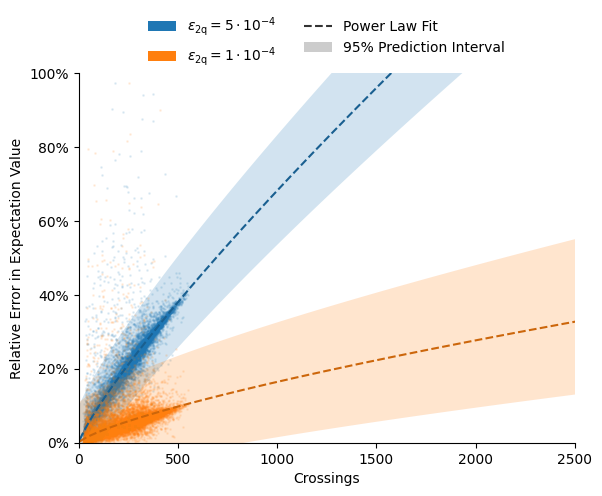

In [26]:
C0, C1 = matplotlib.colors.to_rgb('C0'), matplotlib.colors.to_rgb('C1')
plt.scatter(sim_X, sim_data_5['rel_errs'], s=1, c='C0', alpha=0.1, rasterized=True)
plt.plot(extra_X[:, 0], extra_pred_rel_err_5, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
plt.fill_between(extra_X[:, 0], extra_pred_rel_err_5_pi[:, 0], extra_pred_rel_err_5_pi[:, 1], alpha=0.2, facecolor='C0')
plt.scatter(sim_X, sim_data_1['rel_errs'], s=1, c='C1', alpha=0.1, rasterized=True)
plt.plot(extra_X[:, 0], extra_pred_rel_err_1, '--', color=(C1[0]*0.8, C1[1]*0.8, C1[2]*0.8))
plt.fill_between(extra_X[:, 0], extra_pred_rel_err_1_pi[:, 0], extra_pred_rel_err_1_pi[:, 1], alpha=0.2, facecolor='C1')
plt.ylim(0, 1.0)
plt.xlim(0, 2500)
plt.xlabel("Crossings")
plt.ylabel("Relative Error in Expectation Value")
plt.yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.legend(handles=[
    matplotlib.patches.Patch(facecolor='C0', label="$\\epsilon_{\\mathrm{2q}} = 5\\cdot 10^{-4}$"),
    matplotlib.patches.Patch(facecolor='C1', label="$\\epsilon_{\\mathrm{2q}} = 1\\cdot 10^{-4}$"),
    matplotlib.lines.Line2D([], [], color='k', alpha=0.8, linestyle='--', label="Power Law Fit"),
    matplotlib.patches.Patch(facecolor='k', alpha=0.2, linestyle='--', label="95% Prediction Interval")
], ncols=2, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.19))
seaborn.despine()
plt.gcf().get_size_inches()
plt.savefig("output/rel_err_extrapolation.svg", dpi=200, bbox_inches='tight')

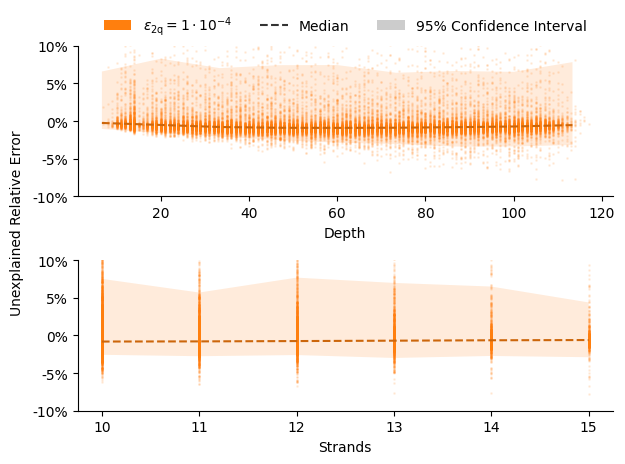

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8))
unex_1 = sim_data_1['rel_errs'] - np.interp(sim_data_1['crossings'], extra_X[:, 0], extra_pred_rel_err_1)
bins = np.linspace(0, 120, 10)
indices = np.digitize(sim_data_1['depths'], bins)
ax1.plot((bins[:-1] + bins[1:])/2, [np.median(unex_1[indices == i+1]) for i in range(len(bins) - 1)], '--', color=dark(C1))
ax1.fill_between((bins[:-1] + bins[1:])/2, [np.quantile(unex_1[indices == i+1], 0.025) for i in range(len(bins) - 1)], [np.quantile(unex_1[indices == i+1], 0.975) for i in range(len(bins) - 1)], facecolor='C1', alpha=0.15)
ax1.scatter(sim_data_1['depths'], unex_1, s=1, c='C1', alpha=0.1, rasterized=True)
# plt.plot(np.linspace(10, 100, 20)[:-1], np.mean(h, axis=1))
# plt.plot(extra_X[:, 0], extra_pred_rel_err_5, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
# plt.fill_between(extra_X[:, 0], extra_pred_rel_err_5_pi[:, 0], extra_pred_rel_err_5_pi[:, 1], alpha=0.2, facecolor='C0')
# plt.scatter(sim_data_1['depths'], sim_data_1['rel_errs'] - np.interp(sim_data_1['crossings'], extra_X[:, 0], extra_pred_rel_err_1), s=1, c='C1', alpha=0.1)
# plt.plot(extra_X[:, 0], extra_pred_rel_err_1, '--', color=(C1[0]*0.8, C1[1]*0.8, C1[2]*0.8))
# plt.fill_between(extra_X[:, 0], extra_pred_rel_err_1_pi[:, 0], extra_pred_rel_err_1_pi[:, 1], alpha=0.2, facecolor='C1')
ax1.set_ylim(-0.1, 0.1)
# plt.imshow(conditional_kde_sd.T, extent=[10, 100, 0.2, -0.2], aspect='auto', cmap='Grays', alpha=0.5)
# plt.xlim(0, 2500)
ax1.set_xlabel("Depth")
# ax1.set_ylabel("Unexplained Relative Error")
ax1.set_yticks([-0.1, -0.05, 0, 0.05, 0.1], ['-10%', '-5%', '0%', '5%', '10%'])
ax1.legend(handles=[
    matplotlib.patches.Patch(facecolor='C1', label="$\\epsilon_{\\mathrm{2q}} = 1\\cdot 10^{-4}$"),
    matplotlib.lines.Line2D([], [], color='k', alpha=0.8, linestyle='--', label="Median"),
    matplotlib.patches.Patch(facecolor='k', alpha=0.2, linestyle='--', label="95% Confidence Interval")
], ncols=3, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.29))

ax2.plot(np.arange(11, 17) - 1, [np.median(unex_1[sim_data_1['qubits'] == q]) for q in range(11, 17)], '--', color=dark(C1))
ax2.fill_between(np.arange(11, 17) - 1, [np.quantile(unex_1[sim_data_1['qubits'] == q], 0.025)  for q in range(11, 17)], [np.quantile(unex_1[sim_data_1['qubits'] == q], 0.975) for q in range(11, 17)], facecolor='C1', alpha=0.15)
ax2.scatter(sim_data_1['qubits'] - 1, unex_1, s=1, c='C1', alpha=0.1, rasterized=True)
# plt.plot(np.linspace(10, 100, 20)[:-1], np.mean(h, axis=1))
# plt.plot(extra_X[:, 0], extra_pred_rel_err_5, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
# plt.fill_between(extra_X[:, 0], extra_pred_rel_err_5_pi[:, 0], extra_pred_rel_err_5_pi[:, 1], alpha=0.2, facecolor='C0')
# plt.scatter(sim_data_1['depths'], sim_data_1['rel_errs'] - np.interp(sim_data_1['crossings'], extra_X[:, 0], extra_pred_rel_err_1), s=1, c='C1', alpha=0.1)
# plt.plot(extra_X[:, 0], extra_pred_rel_err_1, '--', color=(C1[0]*0.8, C1[1]*0.8, C1[2]*0.8))
# plt.fill_between(extra_X[:, 0], extra_pred_rel_err_1_pi[:, 0], extra_pred_rel_err_1_pi[:, 1], alpha=0.2, facecolor='C1')
ax2.set_ylim(-0.1, 0.1)
# plt.imshow(conditional_kde_sd.T, extent=[10, 100, 0.2, -0.2], aspect='auto', cmap='Grays', alpha=0.5)
# plt.xlim(0, 2500)
ax2.set_xlabel("Strands")
ax2.set_ylabel("Unexplained Relative Error")
fig.tight_layout()
ax2.yaxis.set_label_coords(-0.1, 1.25)
ax2.set_yticks([-0.1, -0.05, 0, 0.05, 0.1], ['-10%', '-5%', '0%', '5%', '10%'])
seaborn.despine()

plt.savefig("output/rel_err_unexplained.svg", dpi=200, bbox_inches='tight')


## MPO Error Adjustment

In [28]:
mpo_agg = np.load("processed/mpo_aggregate.npz")

In [29]:
nrei = mpo_agg['normalized_rel_errs_im']
nrei = nrei[(nrei[:, 1] <= 1.0) & (nrei[:, 0] < 1.0)]

In [30]:
reflected_data = np.concatenate([
    nrei,
    nrei * np.array([-1, -1])[None, :] + np.array([0, 2])[None, :],
    nrei * np.array([-1, -1])[None, :] + np.array([2, 0])[None, :],
], axis=0)

In [31]:
cond_kde = sm.nonparametric.KDEMultivariateConditional(reflected_data[:, 1], reflected_data[:, 0], 'c', 'c', bw=[0.08, 0.12])
cond_kde.bw

array([0.08, 0.12])

In [32]:
axis = np.concatenate([np.linspace(-1, 0, 50), np.linspace(0, 1, 100), np.linspace(1, 2, 50)])

In [33]:
grid_vals = (np.stack(np.meshgrid(axis, axis), axis=-1).reshape(-1, 2))
# conditional_kde_e = cond_kde.pdf(grid_vals[:, 1], grid_vals[:, 0]).reshape(200, 200).T
# conditional_kde_e /= np.trapz(conditional_kde_e, axis, axis=1)[:, None]
conditional_kde_e = np.load("processed/conditional_kde_e.npy")

In [34]:
# np.save("processed/conditional_kde_e.npy", conditional_kde_e)

In [35]:
conditional_cdf_e = scipy.integrate.cumulative_trapezoid(conditional_kde_e, axis, axis=1, initial=0)

In [36]:
medians_e = np.apply_along_axis(lambda a: np.interp(0.5, a, axis), 1, conditional_cdf_e)
uq_e = np.apply_along_axis(lambda a: np.interp(0.975, a, axis), 1, conditional_cdf_e)
lq_e = np.apply_along_axis(lambda a: np.interp(0.025, a, axis), 1, conditional_cdf_e)
uq2_e = np.apply_along_axis(lambda a: np.interp(0.75, a, axis), 1, conditional_cdf_e)
lq2_e = np.apply_along_axis(lambda a: np.interp(0.25, a, axis), 1, conditional_cdf_e)

In [37]:
nfi = mpo_agg['normalized_flops_im']
nfi = nfi[(nfi[:, 1] <= 1.0) & (nfi[:, 0] < 1.0)]
reflected_data = np.concatenate([
    nfi,
    nfi * np.array([-1, -1])[None, :] + np.array([0, 0])[None, :],
    nfi * np.array([-1, -1])[None, :] + np.array([2, 2])[None, :],
], axis=0)[::5]
cond_kde = sm.nonparametric.KDEMultivariateConditional(reflected_data[:, 1], reflected_data[:, 0], 'c', 'c', bw=[0.02, 0.02])
cond_kde.bw

array([0.02, 0.02])

In [38]:
axis = np.concatenate([np.linspace(-1, 0, 50), np.linspace(0, 1, 100), np.linspace(1, 2, 50)])
grid_vals = (np.stack(np.meshgrid(axis, axis), axis=-1).reshape(-1, 2))
# conditional_kde = cond_kde.pdf(grid_vals[:, 1], grid_vals[:, 0]).reshape(len(axis), len(axis)).T
# conditional_kde /= np.trapz(conditional_kde, axis, axis=1)[:, None]
conditional_kde = np.load("processed/conditional_kde.npy")
conditional_cdf = scipy.integrate.cumulative_trapezoid(conditional_kde, axis, axis=1, initial=0)

In [39]:
# np.save("processed/conditional_kde.npy", conditional_kde)

In [40]:
medians = np.apply_along_axis(lambda a: np.interp(0.5, a, axis), 1, conditional_cdf)
uq = np.apply_along_axis(lambda a: np.interp(0.975, a, axis), 1, conditional_cdf)
lq = np.apply_along_axis(lambda a: np.interp(0.025, a, axis), 1, conditional_cdf)
uq2 = np.apply_along_axis(lambda a: np.interp(0.75, a, axis), 1, conditional_cdf)
lq2 = np.apply_along_axis(lambda a: np.interp(0.25, a, axis), 1, conditional_cdf)

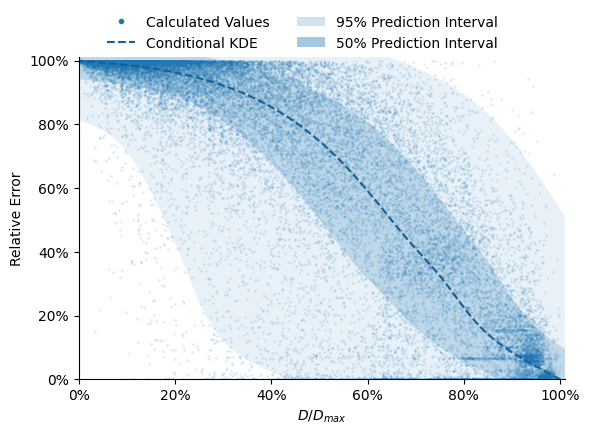

In [41]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

ax1.scatter(nrei[:, 0], nrei[:, 1], s=1, alpha=0.1, c='C0', rasterized=True)
# plt.imshow(conditional_kde[:, ::-1].T, extent=[0, 1, 0, 1], alpha=1.0, cmap='Reds')
ax1.plot(axis, medians_e, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
ax1.fill_between(axis, lq_e, uq_e, facecolor='C0', alpha=0.1)
ax1.fill_between(axis, lq2_e, uq2_e, facecolor='C0', alpha=0.2)
ax1.set_ylim(-0.0, 1.01)
ax1.set_xlim(-0.0, 1.01)
ax1.set_xlabel("$D/D_{max}$")
ax1.set_ylabel("Relative Error")
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])

# plt.scatter(nfi[:, 0], nfi[:, 1], s=1, alpha=0.02, c='C0')
# ax2.scatter(nfi[:, 0], nfi[:, 1], s=1, alpha=0.02, c='C0')
# # plt.imshow(conditional_kde[:, ::-1].T, extent=[0, 1, 0, 1], alpha=1.0, cmap='Reds')
# ax2.plot(axis, medians, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
# ax2.fill_between(axis, lq, uq, facecolor='C0', alpha=0.1)
# ax2.fill_between(axis, lq2, uq2, facecolor='C0', alpha=0.2)
# ax2.set_ylim(-0.00, 1.01) 
# ax2.set_xlim(0.0, 1.0)
# ax2.set_ylabel("FLOPs Derating Factor")
# ax2.set_xlabel("$D/D_{max}$")
# ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
# ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8), linestyle='--', label='Conditional KDE'),
    matplotlib.patches.Patch(facecolor='C0', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.patches.Patch(facecolor='C0', alpha=0.4, label='50% Prediction Interval'),
], frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.46, 1.17))
seaborn.despine()
plt.savefig("output/normalized_kde_rel_err.svg", dpi=200, bbox_inches='tight')

In [42]:
def clamp(x):
    return np.maximum(np.minimum(x, 1), 0)

rel_err_to_im_frac_lq = lambda x: np.interp(x, np.maximum(lq_e[50:150], 0.0)[::-1], np.linspace(0, 1, 100)[::-1])
im_frac_to_flops_frac_lq = lambda x: np.interp(x, np.linspace(0, 1, 100), np.maximum(lq[50:150], 0.0))
rel_err_to_flops_frac_lq = lambda x: np.where(x < 1.0, im_frac_to_flops_frac_lq(rel_err_to_im_frac_lq(np.maximum(x, 0.0))), 0)

derating_5 = rel_err_to_flops_frac_lq(extra_pred_rel_err_5)
derating_5_pi = (
    rel_err_to_flops_frac_lq(extra_pred_rel_err_5_pi[:, 0]),
    rel_err_to_flops_frac_lq(extra_pred_rel_err_5_pi[:, 1])
)
derating_1 = rel_err_to_flops_frac_lq(extra_pred_rel_err_1)
derating_1_pi = (
    rel_err_to_flops_frac_lq(extra_pred_rel_err_1_pi[:, 0]),
    rel_err_to_flops_frac_lq(extra_pred_rel_err_1_pi[:, 1])
)

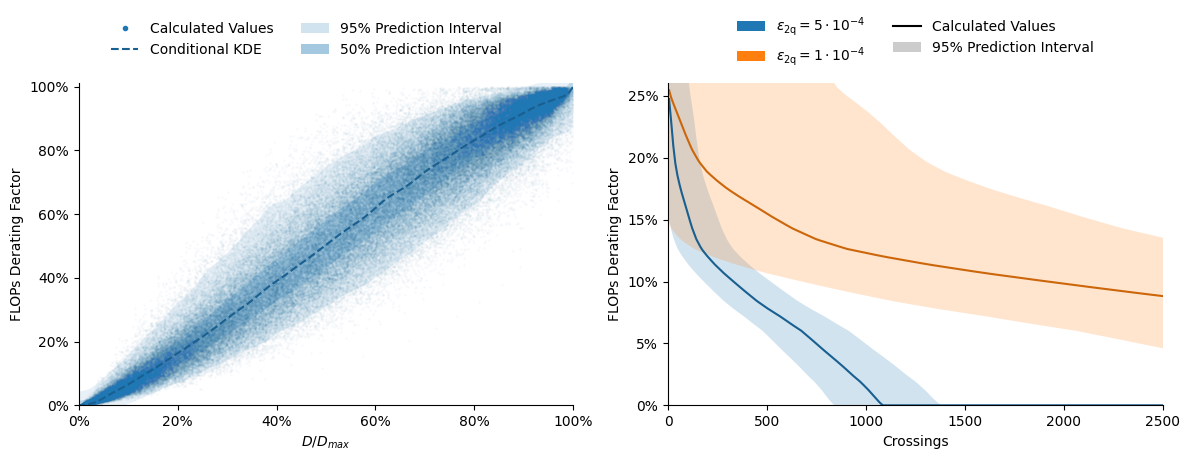

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plt.scatter(nfi[:, 0], nfi[:, 1], s=1, alpha=0.02, c='C0')
ax1.scatter(nfi[:, 0], nfi[:, 1], s=1, alpha=0.02, c='C0', rasterized=True)
# plt.imshow(conditional_kde[:, ::-1].T, extent=[0, 1, 0, 1], alpha=1.0, cmap='Reds')
ax1.plot(axis, medians, '--', color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
ax1.fill_between(axis, lq, uq, facecolor='C0', alpha=0.1)
ax1.fill_between(axis, lq2, uq2, facecolor='C0', alpha=0.2)
ax1.set_ylim(-0.00, 1.01) 
ax1.set_xlim(0.0, 1.0)
ax1.set_ylabel("FLOPs Derating Factor")
ax1.set_xlabel("$D/D_{max}$")
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])


ax2.plot(extra_X[:, 0], derating_5, color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8))
ax2.plot(extra_X[:, 0], derating_1, color=(C1[0]*0.8, C1[1]*0.8, C1[2]*0.8))
ax2.fill_between(extra_X[:, 0], derating_5_pi[0], derating_5_pi[1], facecolor='C0', alpha=0.2)
ax2.fill_between(extra_X[:, 0], derating_1_pi[0], derating_1_pi[1], facecolor='C1', alpha=0.2)
ax2.set_ylabel("FLOPs Derating Factor")
ax2.set_xlabel("Crossings")
# plt.yscale('log')
ax2.set_xlim(0, 2500)
ax2.set_ylim(0.0, 0.26)
ax2.set_yticks([0,0.05,0.1,0.15,0.20,0.25], ['0%', '5%', '10%', '15%', '20%', '25%'])
# plt.yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
seaborn.despine()
fig.tight_layout()
ax2.legend(handles=[
    matplotlib.patches.Patch(facecolor='C0', label="$\\epsilon_{\\mathrm{2q}} = 5\\cdot 10^{-4}$"),
    matplotlib.patches.Patch(facecolor='C1', label="$\\epsilon_{\\mathrm{2q}} = 1\\cdot 10^{-4}$"),
    matplotlib.lines.Line2D([], [], color='k', label='Calculated Values', linestyle='-'),
    matplotlib.patches.Patch(facecolor='k', alpha=0.2, label='95% Prediction Interval'),
], frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.25))
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], color=(C0[0]*0.8, C0[1]*0.8, C0[2]*0.8), linestyle='--', label='Conditional KDE'),
    matplotlib.patches.Patch(facecolor='C0', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.patches.Patch(facecolor='C0', alpha=0.4, label='50% Prediction Interval'),
], frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.46, 1.23))
plt.savefig("output/flops_derating_both.svg", dpi=200, bbox_inches='tight')

## Exact Contraction Costs

In [44]:
exact_data = np.load("processed/exact_contractions.npz")

In [45]:
exact_X = np.stack([exact_data['crossings'], exact_data['depths'], exact_data['strands']], axis=-1)

In [46]:
def exact_target(x, a, b, c, d, e, f):
    return a * np.minimum(x[:, 1], b * x[:, 2])  + c * x[:, 1] + d * x[:, 2] + e*x[:, 0] + f

exact_fit_params, exact_fit_cov = scipy.optimize.curve_fit(exact_target, exact_X, np.log10(exact_data['costs']))
exact_fit_mem_params, exact_fit_mem_cov = scipy.optimize.curve_fit(exact_target, exact_X, np.log10(exact_data['mem']))

In [47]:
var_exact = np.var(exact_target(exact_X, *exact_fit_params) - np.log10(exact_data['costs']))
extra_exact = 10 ** exact_target(extra_X, *exact_fit_params)
extra_exact_pi = (
    10 ** (exact_target(extra_X, *(exact_fit_params - 1.96*np.diag(exact_fit_cov)**0.5)) - 1.96 * var_exact ** 0.5),
    10 ** (exact_target(extra_X, *(exact_fit_params + 1.96*np.diag(exact_fit_cov)**0.5)) + 1.96 * var_exact ** 0.5),
)

var_mem_exact = np.var(exact_target(exact_X, *exact_fit_mem_params) - np.log10(exact_data['mem']))
extra_exact_mem = 10 ** exact_target(extra_X, *exact_fit_mem_params)
extra_exact_mem_pi = (
    10 ** (exact_target(extra_X, *(exact_fit_mem_params - 1.96*np.diag(exact_fit_mem_cov)**0.5)) - 1.96 * var_mem_exact ** 0.5),
    10 ** (exact_target(extra_X, *(exact_fit_mem_params + 1.96*np.diag(exact_fit_mem_cov)**0.5)) + 1.96 * var_mem_exact ** 0.5),
)

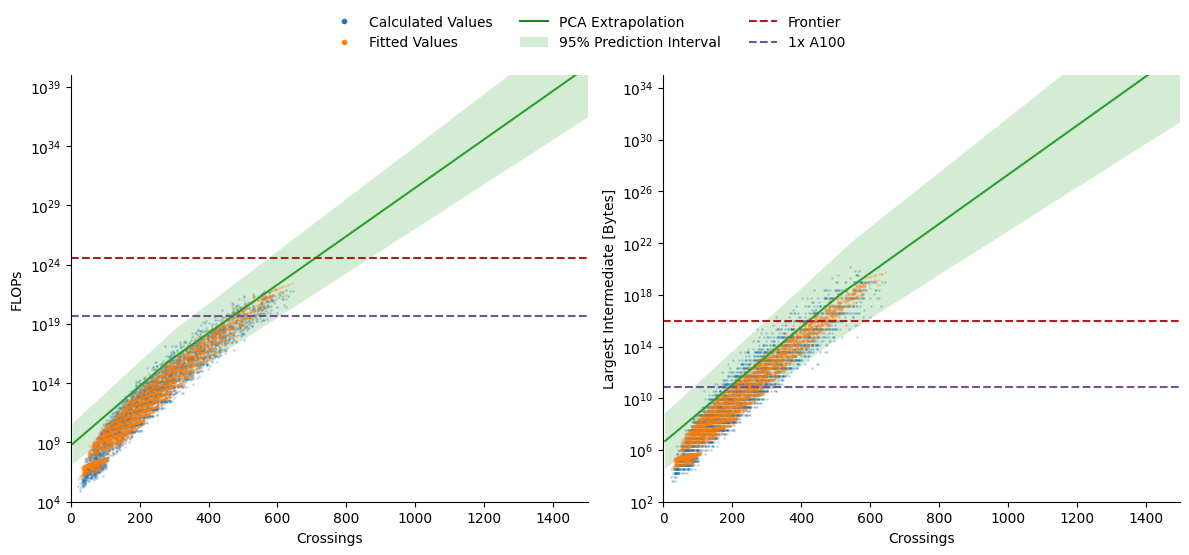

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(extra_X[:, 0], extra_exact, color=C2)
ax1.fill_between(extra_X[:, 0], extra_exact_pi[0], extra_exact_pi[1], alpha=0.2, facecolor=C2)
ax1.scatter(exact_X[:, 0], exact_data['costs'], s=1, color=C0, alpha=0.2, rasterized=True)
ax1.scatter(exact_X[:, 0], 10 ** exact_target(exact_X, *exact_fit_params), s=1, color=C1, alpha=0.2, rasterized=True)
ax1.set_yscale('log')
ax1.set_xlim(0, 1500)
ax1.set_ylim(1e4, 1e40)
ax1.set_xlabel("Crossings")
ax1.set_ylabel("FLOPs")
ax1.axhline(1.353e18 * 3600 * 24 * 30, color=dark(C3), linestyle='--')
ax1.axhline(19.5e12 * 3600 * 24 * 30, color=dark(C4), linestyle='--')

ax2.plot(extra_X[:, 0], 8 * extra_exact_mem, color=C2)
ax2.fill_between(extra_X[:, 0], 8 * extra_exact_mem_pi[0], 8 * extra_exact_mem_pi[1], alpha=0.2, facecolor=C2)
ax2.scatter(exact_X[:, 0], 8 * exact_data['mem'], s=1, color=C0, alpha=0.2, rasterized=True)
ax2.scatter(exact_X[:, 0], 8 * 10 ** exact_target(exact_X, *exact_fit_mem_params), s=1, color=C1, alpha=0.2, rasterized=True)
ax2.set_yscale('log')
ax2.set_xlim(0, 1500)
ax2.set_ylim(1e2, 1e35)
ax2.set_xlabel("Crossings")
ax2.set_ylabel("Largest Intermediate [Bytes]")
ax2.axhline(80e9, color=dark(C4), linestyle='--')
ax2.axhline(9.2e15, color=dark(C3), linestyle='--')

fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], marker='.', color='C1', label='Fitted Values', linestyle=''),
    matplotlib.lines.Line2D([], [], color=dark(C2), label='PCA Extrapolation'),
    matplotlib.patches.Patch(facecolor='C2', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.lines.Line2D([], [], color=dark(C3), linestyle='--', label='Frontier'),
    matplotlib.lines.Line2D([], [], color=dark(C4), linestyle='--', label='1x A100')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(1.0, 1.17))

seaborn.despine()

plt.savefig("output/exact_extrapolation.svg", dpi=200, bbox_inches='tight')

## Kauffman TN Contraction

In [49]:
kbtensor_data = np.load("processed/kbtensor_costs.npz")
kbtensor_X = np.stack([kbtensor_data['crossings'], kbtensor_data['depths'], kbtensor_data['strands']], axis=-1)

In [50]:
def kbtensor_target(x, a, b, c, d, e, f):
    return a * np.minimum(x[:, 1], b * x[:, 2])  + c * x[:, 1] + d * x[:, 2] + e*x[:, 0] + f

kbtensor_fit_params, kbtensor_fit_cov = scipy.optimize.curve_fit(kbtensor_target, kbtensor_X, kbtensor_data['costs'])
kbtensor_fit_mem_params, kbtensor_fit_mem_cov = scipy.optimize.curve_fit(kbtensor_target, kbtensor_X, np.log10(2) * kbtensor_data['mem'])

In [51]:
var_kbtensor = np.var(kbtensor_target(kbtensor_X, *kbtensor_fit_params) - kbtensor_data['costs'])
extra_kbtensor = 10 ** kbtensor_target(extra_X, *kbtensor_fit_params)
extra_kbtensor_pi = (
    10 ** (kbtensor_target(extra_X, *(kbtensor_fit_params - 1.96*np.diag(kbtensor_fit_cov)**0.5)) - 1.96 * var_kbtensor ** 0.5),
    10 ** (kbtensor_target(extra_X, *(kbtensor_fit_params + 1.96*np.diag(kbtensor_fit_cov)**0.5)) + 1.96 * var_kbtensor ** 0.5),
)

var_mem_kbtensor = np.var(kbtensor_target(kbtensor_X, *kbtensor_fit_mem_params) - np.log10(2) * kbtensor_data['mem'])
extra_kbtensor_mem = 10 ** kbtensor_target(extra_X, *kbtensor_fit_mem_params)
extra_kbtensor_mem_pi = (
    10 ** (kbtensor_target(extra_X, *(kbtensor_fit_mem_params - 1.96*np.diag(kbtensor_fit_mem_cov)**0.5)) - 1.96 * var_mem_kbtensor ** 0.5),
    10 ** (kbtensor_target(extra_X, *(kbtensor_fit_mem_params + 1.96*np.diag(kbtensor_fit_mem_cov)**0.5)) + 1.96 * var_mem_kbtensor ** 0.5),
)

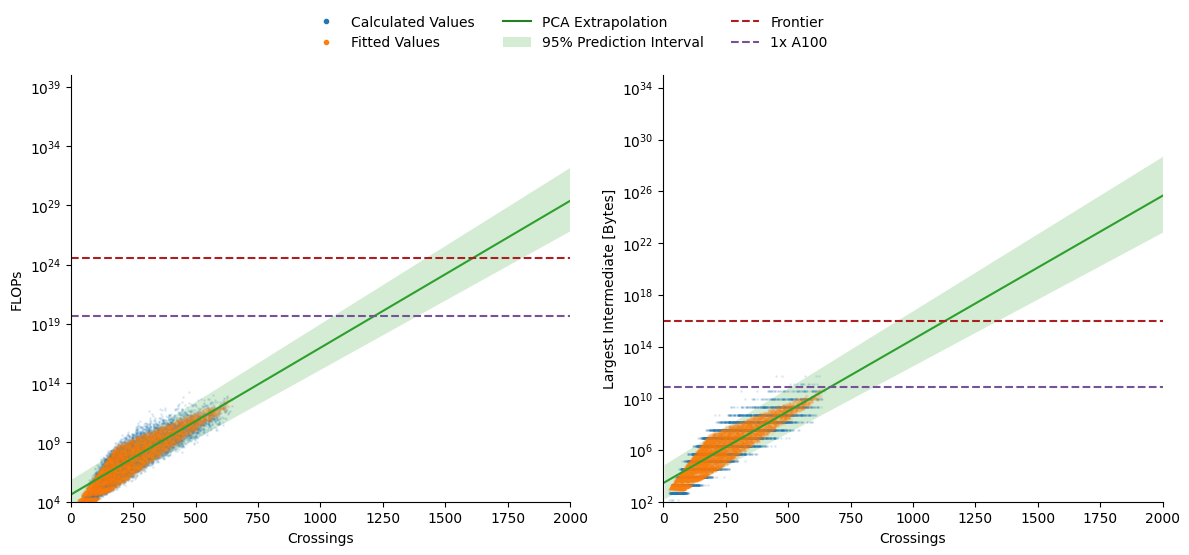

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(extra_X[:, 0], extra_kbtensor, color=C2)
ax1.fill_between(extra_X[:, 0], extra_kbtensor_pi[0], extra_kbtensor_pi[1], alpha=0.2, facecolor=C2)
ax1.scatter(kbtensor_X[:, 0], 10 ** kbtensor_data['costs'], s=1, color=C0, alpha=0.1, rasterized=True)
ax1.scatter(kbtensor_X[:, 0], 10 ** kbtensor_target(kbtensor_X, *kbtensor_fit_params), s=1, color=C1, alpha=0.1, rasterized=True)
ax1.set_yscale('log')
ax1.set_xlim(0, 2000)
ax1.set_ylim(1e4, 1e40)
ax1.set_xlabel("Crossings")
ax1.set_ylabel("FLOPs")
ax1.axhline(1.353e18 * 3600 * 24 * 30, color=dark(C3), linestyle='--')
ax1.axhline(19.5e12 * 3600 * 24 * 30, color=dark(C4), linestyle='--')

ax2.plot(extra_X[:, 0], 8 * extra_kbtensor_mem, color=C2)
ax2.fill_between(extra_X[:, 0], 8 * extra_kbtensor_mem_pi[0], 8 * extra_kbtensor_mem_pi[1], alpha=0.2, facecolor=C2)
ax2.scatter(kbtensor_X[:, 0], 8 * 2 ** kbtensor_data['mem'], s=1, color=C0, alpha=0.1, rasterized=True)
ax2.scatter(kbtensor_X[:, 0], 8 * 10 ** kbtensor_target(kbtensor_X, *kbtensor_fit_mem_params), s=1, color=C1, alpha=0.1, rasterized=True)
ax2.set_yscale('log')
ax2.set_xlim(0, 2000)
ax2.set_ylim(1e2, 1e35)
ax2.set_xlabel("Crossings")
ax2.set_ylabel("Largest Intermediate [Bytes]")
ax2.axhline(80e9, color=dark(C4), linestyle='--')
ax2.axhline(9.2e15, color=dark(C3), linestyle='--')

fig.tight_layout()
ax1.legend(handles=[
    matplotlib.lines.Line2D([], [], marker='.', color='C0', label='Calculated Values', linestyle=''),
    matplotlib.lines.Line2D([], [], marker='.', color='C1', label='Fitted Values', linestyle=''),
    matplotlib.lines.Line2D([], [], color=dark(C2), label='PCA Extrapolation'),
    matplotlib.patches.Patch(facecolor='C2', alpha=0.2, label='95% Prediction Interval'),
    matplotlib.lines.Line2D([], [], color=dark(C3), linestyle='--', label='Frontier'),
    matplotlib.lines.Line2D([], [], color=dark(C4), linestyle='--', label='1x A100')
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(1.0, 1.17))

seaborn.despine()

plt.savefig("output/kbtensor_extrapolation.svg", dpi=200, bbox_inches='tight')

## Times to Solution

In [53]:
density_factor = 0.618
time_per_depth = 30 / 1000
shots = 10000

depth_2q = 2*density_factor*(extra_X[:, 2] - 2) + 3*extra_X[:, 1]
time_per_shot = depth_2q * time_per_depth
cfev_time = shots * time_per_shot

In [54]:
qbf_factor = 0.25
sv_flops_1 = np.where(extra_pred_rel_err_1 < 1.0, np.maximum(4.0 / np.maximum(extra_pred_rel_err_1, 4.0/100), 1.0), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor
sv_flops_1_pi = (
    np.where(extra_pred_rel_err_1_pi[:, 0] < 1.0, np.maximum(4.0 / np.maximum(extra_pred_rel_err_1_pi[:, 0], 4.0/100), 1.0), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor,
    np.where(extra_pred_rel_err_1_pi[:, 1] < 1.0, np.maximum(4.0 / np.maximum(extra_pred_rel_err_1_pi[:, 1], 4.0/100), 1.0), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor,
)
sv_flops_5 = np.where(extra_pred_rel_err_5 < 1.0, (4.0 / np.maximum(extra_pred_rel_err_5, 4.0/100)), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor
sv_flops_5_pi = (
    np.where(extra_pred_rel_err_5_pi[:, 0] < 1.0, np.maximum(4.0 / np.maximum(extra_pred_rel_err_5_pi[:, 0], 4.0/100), 1.0), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor,
    np.where(extra_pred_rel_err_5_pi[:, 1] < 1.0, np.maximum(4.0 / np.maximum(extra_pred_rel_err_5_pi[:, 1], 4.0/100), 1.0), 0.0) * (32 * 1.618 ** extra_X[:, 2] * extra_X[:, 0]) / qbf_factor,
)
sv_mem = 8 * 1.618 ** extra_X[:, 2]

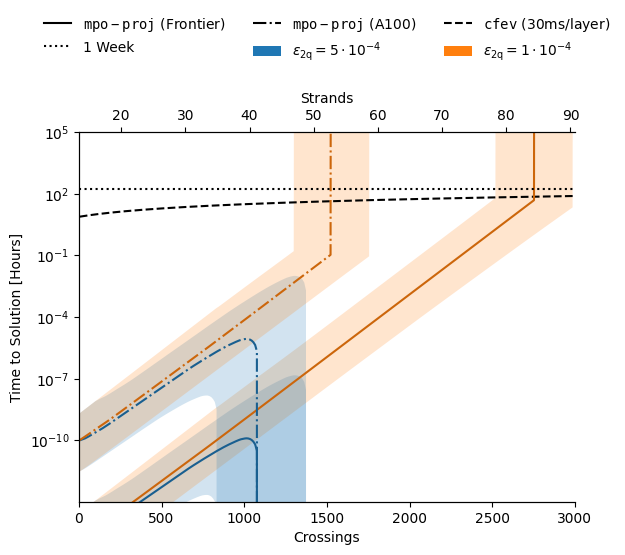

In [55]:
plt.plot(extra_X[:, 0], cfev_time/3600, 'k--')
plt.plot(extra_X[:, 0], (derating_5 * (10 ** extra_preds['mean']) / 1.353e18) / 3600, color=dark(C0))
plt.fill_between(extra_X[:, 0], (derating_5_pi[0] * (10 ** extra_preds['obs_ci_lower']) / 1.353e18) / 3600, (derating_5_pi[1] * (10 ** extra_preds['obs_ci_upper']) / 1.353e18) / 3600, facecolor='C0', alpha=0.2)
plt.plot(extra_X[:, 0], (np.where(8*10**extra_preds_mem['mean'] < 9.2e15, derating_1 * (10 ** extra_preds['mean']), 1e100) / 1.353e18) / 3600, color=dark(C1))
plt.fill_between(extra_X[:, 0], (np.where(8*10**extra_preds_mem['obs_ci_lower'] < 9.2e15, derating_1_pi[0] * (10 ** extra_preds['obs_ci_lower']), 1e100) / 1.353e18) / 3600, (np.where(8*10**extra_preds_mem['obs_ci_upper'] < 9.2e15, derating_1_pi[1] * (10 ** extra_preds['obs_ci_upper']), 1e100) / 1.353e18) / 3600, facecolor='C1', alpha=0.2)
plt.plot(extra_X[:, 0], (derating_5 * (10 ** extra_preds['mean']) / 19.5e12) / 3600, color=dark(C0), linestyle='-.')
plt.fill_between(extra_X[:, 0], (derating_5_pi[0] * (10 ** extra_preds['obs_ci_lower']) / 19.5e12) / 3600, (derating_5_pi[1] * (10 ** extra_preds['obs_ci_upper']) / 19.5e12) / 3600, facecolor='C0', alpha=0.2)
plt.plot(extra_X[:, 0], (np.where(8*10**extra_preds_mem['mean'] < 80e9, derating_1 * (10 ** extra_preds['mean']), 1e100) / 19.5e12) / 3600, color=dark(C1), linestyle='-.')
plt.fill_between(extra_X[:, 0], (np.where(8*10**extra_preds_mem['obs_ci_lower'] < 80e9, derating_1_pi[0] * (10 ** extra_preds['obs_ci_lower']), 1e100) / 19.5e12) / 3600, (np.where(8*10**extra_preds_mem['obs_ci_upper'] < 80e9, derating_1_pi[1] * (10 ** extra_preds['obs_ci_upper']), 1e100) / 19.5e12) / 3600, facecolor='C1', alpha=0.2)
plt.yscale('log')
plt.xlabel("Crossings")
plt.ylabel("Time to Solution [Hours]")
plt.yticks(np.logspace(-10, 8, 7, 10))
plt.axhline(24*7, c='k', linestyle=':')
plt.legend(handles=[
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{mpo-proj}$ (Frontier)', linestyle='-'),
    matplotlib.lines.Line2D([], [], color='k', label='1 Week', linestyle=':'),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{mpo-proj}$ (A100)', linestyle='-.'),
    matplotlib.patches.Patch(facecolor='C0', label="$\\epsilon_{\\mathrm{2q}} = 5\\cdot 10^{-4}$"),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{cfev}$ (30ms/layer)', linestyle='--'),
    matplotlib.patches.Patch(facecolor='C1', label="$\\epsilon_{\\mathrm{2q}} = 1\\cdot 10^{-4}$"),
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.xlim(0, 3000)
plt.ylim(10**-13, 10**5)
ax2 = plt.twiny()
ax2.set_xlabel("Strands")
ax2.set_xlim(np.interp(0, extra_X[:, 0], extra_X[:, 2] - 1), np.interp(3000, extra_X[:, 0], extra_X[:, 2] - 1))
seaborn.despine(top=False)

plt.savefig("output/time_sol_mpo.svg", dpi=200, bbox_inches='tight')

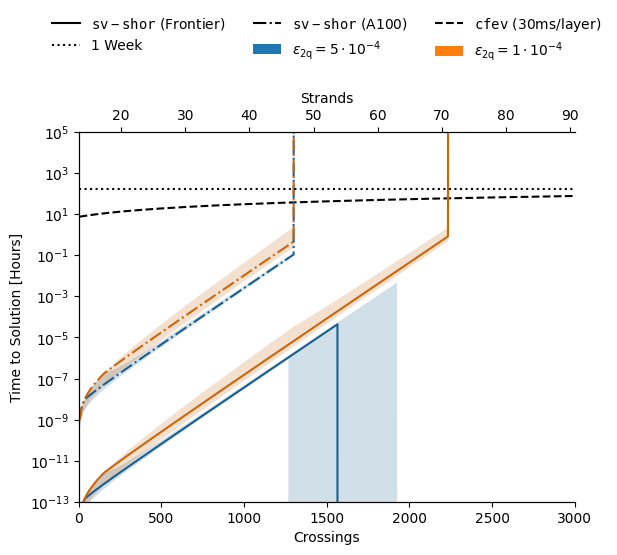

In [56]:
plt.plot(extra_X[:, 0], cfev_time / 3600, 'k--')
plt.plot(extra_X[:, 0], (np.where(sv_mem < 80e9, sv_flops_5 / 19.5e12, 1e100)) / 3600, linestyle='-.', color=dark(C0))
plt.plot(extra_X[:, 0], (np.where(sv_mem < 80e9, 1, 1e100) * sv_flops_1 / 19.5e12) / 3600, linestyle='-.', color=dark(C1))
plt.fill_between(extra_X[:, 0], (np.where(sv_mem < 60e9, sv_flops_5_pi[0] / 19.5e12, 1e100)) / 3600, (np.where(sv_mem < 60e9, sv_flops_5_pi[1] / 19.5e12, 1e100)) / 3600, alpha=0.2, facecolor=dark(C0))
plt.fill_between(extra_X[:, 0], (np.where(sv_mem < 80e9, sv_flops_1_pi[0] / 19.5e12, 1e100)) / 3600, (np.where(sv_mem < 80e9, sv_flops_1_pi[1] / 19.5e12, 1e100)) / 3600, alpha=0.2, facecolor=dark(C1))
plt.plot(extra_X[:, 0], (np.where(sv_mem < 9.2e15, 1, 1e100) * sv_flops_5 / 1.353e18) / 3600, linestyle='-', color=dark(C0))
plt.plot(extra_X[:, 0], (np.where(sv_mem < 9.2e15, sv_flops_1 / 1.353e18, 1e100)) / 3600, linestyle='-', color=dark(C1))
plt.fill_between(extra_X[:, 0], (np.where(sv_mem < 9.2e15, sv_flops_5_pi[0] / 1.353e18, 1e100)) / 3600, (np.where(sv_mem < 9.2e15, sv_flops_5_pi[1] / 1.353e18, 1e100)) / 3600, alpha=0.2, facecolor=dark(C0))
plt.fill_between(extra_X[:, 0], (np.where(sv_mem < 9.2e15, sv_flops_1_pi[0] / 1.353e18, 1e100)) / 3600, (np.where(sv_mem < 9.2e15, sv_flops_1_pi[1] / 1.353e18, 1e100)) / 3600, alpha=0.2, facecolor=dark(C1))
plt.yscale('log')
plt.xlabel("Crossings")
plt.ylabel("Time to Solution [Hours]")
plt.axhline(24*7, c='k', linestyle=':')
plt.legend(handles=[
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{sv-shor}$ (Frontier)', linestyle='-'),
    matplotlib.lines.Line2D([], [], color='k', label='1 Week', linestyle=':'),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{sv-shor}$ (A100)', linestyle='-.'),
    matplotlib.patches.Patch(facecolor='C0', label="$\\epsilon_{\\mathrm{2q}} = 5\\cdot 10^{-4}$"),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{cfev}$ (30ms/layer)', linestyle='--'),
    matplotlib.patches.Patch(facecolor='C1', label="$\\epsilon_{\\mathrm{2q}} = 1\\cdot 10^{-4}$"),
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.xlim(0, 3000)
plt.ylim(10**-13, 10**5)
ax2 = plt.twiny()
ax2.set_xlabel("Strands")
ax2.set_xlim(np.interp(0, extra_X[:, 0], extra_X[:, 2] - 1), np.interp(3000, extra_X[:, 0], extra_X[:, 2] - 1))
seaborn.despine(top=False)

plt.savefig("output/time_sol_sv.svg", dpi=200, bbox_inches='tight')

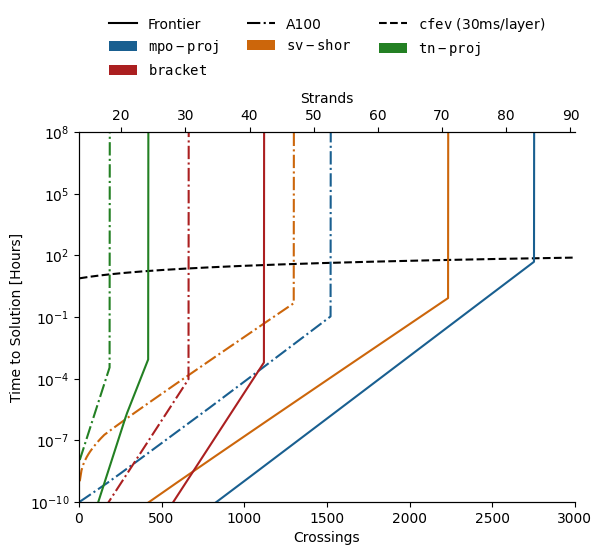

In [57]:
plt.plot(extra_X[:, 0], cfev_time / 3600, 'k--')
plt.plot(extra_X[:, 0], (np.where(sv_mem < 80e9, 1, 1e100) * sv_flops_1 / 19.5e12) / 3600, linestyle='-.', color=dark(C1))
plt.plot(extra_X[:, 0], np.where(sv_mem < 9.2e15, sv_flops_1 / 1.353e18, 1e100)/3600, linestyle='-', color=dark(C1))
plt.plot(extra_X[:, 0], (np.where(8*10**extra_preds_mem['mean'] < 9.2e15, derating_1 * (10 ** extra_preds['mean']), 1e100) / 1.353e18) / 3600, color=dark(C0))
plt.plot(extra_X[:, 0], (np.where(8*10**extra_preds_mem['mean'] < 80e9, derating_1 * (10 ** extra_preds['mean']), 1e100) / 19.5e12)/3600, color=dark(C0), linestyle='-.')
plt.plot(extra_X[:, 0], np.where(8 * extra_exact_mem < 9.2e15, extra_exact / 1.353e18, 1e100)/3600, color=dark(C2))
plt.plot(extra_X[:, 0], np.where(8 * extra_exact_mem < 80e9, extra_exact / 19.5e12, 1e100)/3600, color=dark(C2), linestyle='-.')
plt.plot(extra_X[:, 0], np.where(8 * extra_kbtensor_mem < 9.2e15, extra_kbtensor / 1.353e18, 1e100)/3600, color=dark(C3))
plt.plot(extra_X[:, 0], np.where(8 * extra_kbtensor_mem < 80e9, extra_kbtensor / 19.5e12, 1e100)/3600, color=dark(C3), linestyle='-.')


plt.yscale('log')
plt.xlabel("Crossings")
plt.ylabel("Time to Solution [Hours]")
# plt.axhline(24*7, c='k', linestyle=':')
plt.legend(handles=[
    matplotlib.lines.Line2D([], [], color='k', label='Frontier', linestyle='-'),
    matplotlib.patches.Patch(facecolor=dark(C0), label="$\\mathtt{mpo-proj}$"),
    matplotlib.patches.Patch(facecolor=dark(C3), label="$\\mathtt{bracket}$"),
    matplotlib.lines.Line2D([], [], color='k', label='A100', linestyle='-.'),
    matplotlib.patches.Patch(facecolor=dark(C1), label="$\\mathtt{sv-shor}$"),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{cfev}$ (30ms/layer)', linestyle='--'),
    matplotlib.patches.Patch(facecolor=dark(C2), label="$\\mathtt{tn-proj}$"),
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.xlim(0, 3000)
plt.ylim(10**-10, 10**8)
ax2 = plt.twiny()
ax2.set_xlabel("Strands")
ax2.set_xlim(np.interp(0, extra_X[:, 0], extra_X[:, 2] - 1), np.interp(3000, extra_X[:, 0], extra_X[:, 2] - 1))
seaborn.despine(top=False)

plt.savefig("output/time_sol_multi.svg", dpi=200, bbox_inches='tight')

## Emulator Results

In [58]:
emulator_data = np.load("processed/emulator.npz")
em = collections.namedtuple('em', emulator_data.keys())(**emulator_data)

In [59]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    import matplotlib.patches
    import matplotlib.transforms

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = matplotlib.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

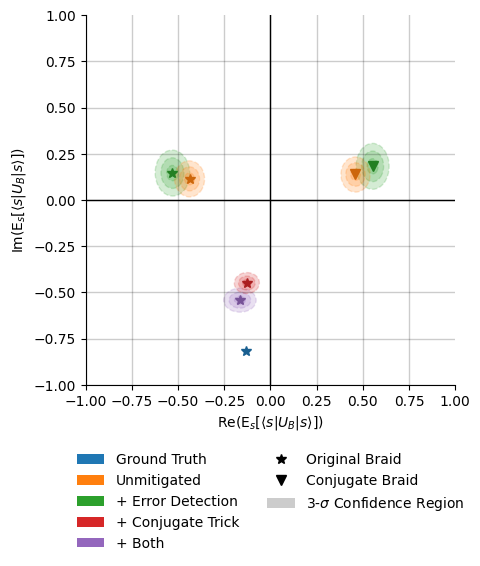

In [61]:
def point_and_CI(q, q_reps, c, marker='*'):
    plt.plot([q.real], [q.imag], marker, c=dark(c), markersize=7)
    confidence_ellipse(q_reps.real, q_reps.imag, plt.gca(), 1.0, facecolor=c, edgecolor=c, linestyle='--', alpha=0.2)
    confidence_ellipse(q_reps.real, q_reps.imag, plt.gca(), 2.0, facecolor=c, edgecolor=c, linestyle='--', alpha=0.2)
    confidence_ellipse(q_reps.real, q_reps.imag, plt.gca(), 3.0, facecolor=c, edgecolor=c, linestyle='--', alpha=0.2)

plt.plot([em.actual.real], [em.actual.imag], '*', c=dark(C0), markersize=7)
point_and_CI(em.z_mit, em.z_mit_reps, C2)
point_and_CI(em.z_unmit, em.z_unmit_reps, C1)
point_and_CI(em.zc_mit, em.zc_mit_reps, C2, 'v')
point_and_CI(em.zc_unmit, em.zc_unmit_reps, C1, 'v')
point_and_CI(em.conj_mit, em.conj_mit_reps, C4)
point_and_CI(em.conj_unmit, em.conj_unmit_reps, C3)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xticks(np.linspace(-1, 1, 9))
plt.yticks(np.linspace(-1, 1, 9))
plt.axhline(0, c='k', alpha=1.0, linewidth=1)
plt.axvline(0, c='k', alpha=1.0, linewidth=1)
for z in np.linspace(-1, 1, 9)[:-1]:
    plt.axhline(z, c='k', alpha=0.2, linewidth=1)
    plt.axvline(z, c='k', alpha=0.2, linewidth=1)
seaborn.despine()
plt.gca().set_aspect('equal')
plt.xlabel("$\\mathrm{Re}(\\mathrm{E}_s[\\langle s|U_B|s\\rangle])$")
plt.ylabel("$\\mathrm{Im}(\\mathrm{E}_s[\\langle s|U_B|s\\rangle])$")
plt.legend(handles=[
    matplotlib.patches.Patch(facecolor='C0', label='Ground Truth'),
    matplotlib.patches.Patch(facecolor='C1', label='Unmitigated'),
    matplotlib.patches.Patch(facecolor='C2', label='+ Error Detection'),
    matplotlib.patches.Patch(facecolor='C3', label='+ Conjugate Trick'),
    matplotlib.patches.Patch(facecolor='C4', label='+ Both'),
    matplotlib.lines.Line2D([], [], color='k', label='Original Braid', linestyle='', marker='*', markersize=7),
    matplotlib.lines.Line2D([], [], color='k', label='Conjugate Braid', linestyle='', marker='v', markersize=7),
    matplotlib.patches.Patch(facecolor='k', alpha=0.2, label='3-$\\sigma$ Confidence Region'),
    matplotlib.patches.Patch(facecolor='none'),
], frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.5, -0.15))

plt.savefig("output/emulator_results.svg", dpi=200, bbox_inches='tight')

In [62]:
np.std(em.conj_mit_reps) / abs(em.conj_mit)

0.06422387034991264

## Power Consumption

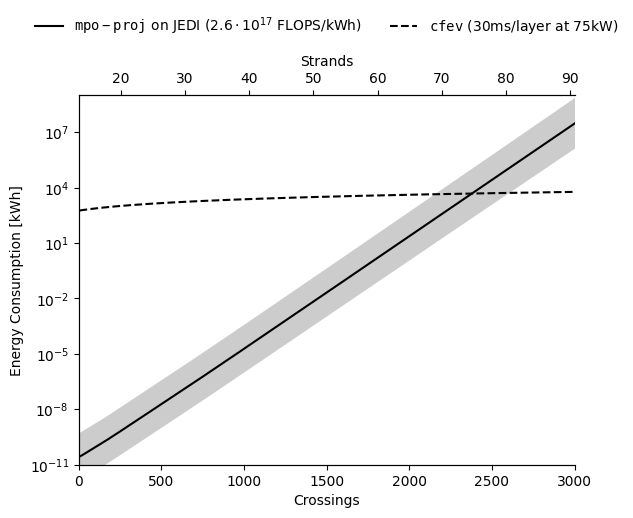

In [63]:
plt.plot(extra_X[:, 0], (75000 * cfev_time) / 3.6e6, 'k--')
# plt.plot(extra_X[:, 0], (np.where(sv_mem < 80e9, 1, 1e100) * sv_flops_1 / 19.5e12) / 3600, linestyle='-.', color=dark(C1))
# plt.plot(extra_X[:, 0], np.where(sv_mem < 9.2e15, sv_flops_1 / 1.353e18, 1e100)/3600, linestyle='-', color=dark(C1))
plt.plot(extra_X[:, 0], ((derating_1 * (10 ** extra_preds['mean'])) / (72.7e9)) / 3.6e6, color='k')
plt.fill_between(extra_X[:, 0], ((derating_1 * (10 ** extra_preds['obs_ci_upper'])) / (72.7e9)) / 3.6e6, ((derating_1 * (10 ** extra_preds['obs_ci_lower'])) / (72.7e9)) / 3.6e6, facecolor='k', alpha=0.2)
# plt.plot(extra_X[:, 0], (np.where(8*10**extra_preds_mem['mean'] < 80e9, derating_1 * (10 ** extra_preds['mean']), 1e100) / 19.5e12)/3600, color=dark(C0), linestyle='-.')
# plt.plot(extra_X[:, 0], np.where(8 * extra_exact_mem < 9.2e15, extra_exact / 1.353e18, 1e100)/3600, color=dark(C2))
# plt.plot(extra_X[:, 0], np.where(8 * extra_exact_mem < 80e9, extra_exact / 19.5e12, 1e100)/3600, color=dark(C2), linestyle='-.')
# plt.plot(extra_X[:, 0], np.where(8 * extra_kbtensor_mem < 9.2e15, extra_kbtensor / 1.353e18, 1e100)/3600, color=dark(C3))
# plt.plot(extra_X[:, 0], np.where(8 * extra_kbtensor_mem < 80e9, extra_kbtensor / 19.5e12, 1e100)/3600, color=dark(C3), linestyle='-.')


plt.yscale('log')
plt.xlabel("Crossings")
plt.ylabel("Energy Consumption [kWh]")
# plt.axhline(24*7, c='k', linestyle=':')
plt.legend(handles=[
    matplotlib.lines.Line2D([], [], color='k', label="$\\mathtt{mpo-proj}$ on JEDI ($2.6\\cdot 10^{17}$ FLOPS/kWh)"),
    matplotlib.lines.Line2D([], [], color='k', label='$\\mathtt{cfev}$ (30ms/layer at 75kW)', linestyle='--'),
], frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.25))
plt.xlim(0, 3000)
plt.ylim(10**-11, 10**9)
ax2 = plt.twiny()
ax2.set_xlabel("Strands")
ax2.set_xlim(np.interp(0, extra_X[:, 0], extra_X[:, 2] - 1), np.interp(3000, extra_X[:, 0], extra_X[:, 2] - 1))
seaborn.despine(top=False)

plt.savefig("output/energy_consumption.svg", dpi=200, bbox_inches='tight')

# Device Results

In [64]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor="none", **kwargs):
    import matplotlib.patches
    import matplotlib.transforms

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs,
    )

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = (
        matplotlib.transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean_x, mean_y)
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def point_and_CI(qq, c, marker="*", label=None):
    q, q_reps = qq
    plt.plot([q.real], [q.imag], marker, c=dark(c), markersize=7, label=label)
    q_reps = np.array(q_reps)
    confidence_ellipse(
        q_reps.real,
        q_reps.imag,
        plt.gca(),
        1.0,
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )
    confidence_ellipse(
        q_reps.real,
        q_reps.imag,
        plt.gca(),
        2.0,
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )
    confidence_ellipse(
        q_reps.real,
        q_reps.imag,
        plt.gca(),
        3.0,
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )

In [65]:
import pickle
b_nomit, c_nomit, b_mit, c_mit, avg_then_mit_nf, avg_then_mit, mit_then_avg_nf, mit_then_avg = pickle.load(open("processed/h2-2_interleaved.pkl", "rb"))

In [66]:
import scipy.spatial
import scipy.stats

def confidence_region_params(x, y, n_std=3.0):
    points = np.stack([x, y], axis=-1)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    indices = np.argsort(((mean_x - x)/std_x)**2 + ((mean_y - y)/std_y)**2)
    print(len(indices))
    frac = scipy.stats.norm.cdf(n_std) - scipy.stats.norm.cdf(-n_std)
    wpoints = points[indices[:int(np.ceil(indices.shape[0]*frac))]]
    hull = scipy.spatial.ConvexHull(wpoints)
    return wpoints[hull.vertices]


def confidence_region_plot(region, ax, **kwargs):
    ax.fill(region[:, 0], region[:, 1], **kwargs)

def point_and_CI_precompute(qq):
    return (
        confidence_region_params(qq[1].real, qq[1].imag, 1.0), 
        confidence_region_params(qq[1].real, qq[1].imag, 2.0),
        confidence_region_params(qq[1].real, qq[1].imag, 3.0)
    )

def point_and_CI_minimum(qq, params, c, marker="*", label=None):
    q, q_reps = qq
    plt.plot([q.real], [q.imag], marker, c=dark(c), markersize=7, label=label)
    q_reps = np.array(q_reps)
    confidence_region_plot(
        params[0],
        plt.gca(),
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )
    confidence_region_plot(
        params[1],
        plt.gca(),
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )
    confidence_region_plot(
        params[2],
        plt.gca(),
        facecolor=c,
        edgecolor=c,
        linestyle="--",
        alpha=0.2,
    )


In [67]:
mit_then_avg_params = point_and_CI_precompute(mit_then_avg)

100000
100000
100000


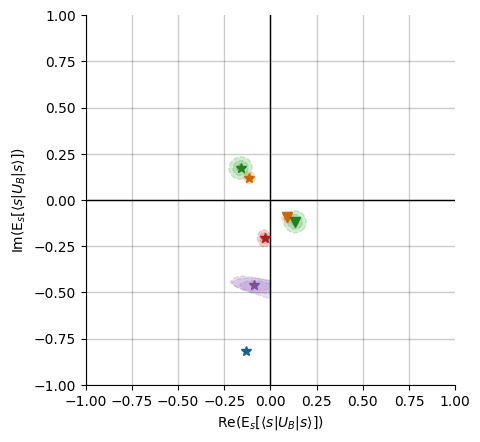

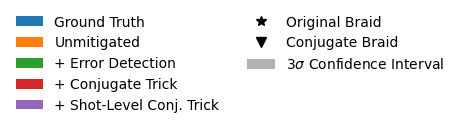

In [68]:
import matplotlib.patches as mp
import matplotlib.lines as ml

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, c='k', alpha=1.0, linewidth=1)
plt.axvline(0, c='k', alpha=1.0, linewidth=1)
for z in np.linspace(-1, 1, 9)[:-1]:
    plt.axhline(z, c='k', alpha=0.2, linewidth=1)
    plt.axvline(z, c='k', alpha=0.2, linewidth=1)
seaborn.despine()
plt.gca().set_aspect('equal')
plt.xlabel("$\\mathrm{Re}(\\mathrm{E}_s[\\langle s|U_B|s\\rangle])$")
plt.ylabel("$\\mathrm{Im}(\\mathrm{E}_s[\\langle s|U_B|s\\rangle])$")

plt.plot([-0.13274241625389036], [-0.817078298378928], color=dark(C0), marker='*', markersize=7)
point_and_CI(b_nomit, C1)
point_and_CI(c_nomit, C1, marker='v')
point_and_CI(b_mit, C2)
point_and_CI(c_mit, C2, marker='v')
point_and_CI(avg_then_mit, C3)
point_and_CI_minimum(mit_then_avg, mit_then_avg_params, C4)
plt.gca().set_aspect('equal')

plt.savefig('output/h2-2_interleaved_plot.svg', dpi=200, bbox_inches='tight')

fig = plt.figure()
ax = fig.add_axes([0, 0, 0, 0])
ax.legend(handles=[
    mp.Patch(facecolor='C0', label='Ground Truth'),
    mp.Patch(facecolor='C1', label='Unmitigated'),
    mp.Patch(facecolor='C2', label='+ Error Detection'),
    mp.Patch(facecolor='C3', label='+ Conjugate Trick'),
    mp.Patch(facecolor='C4', label='+ Shot-Level Conj. Trick'),
    ml.Line2D([], [], linestyle='none', color='k', marker='*', markersize=7, label='Original Braid'),
    ml.Line2D([], [], linestyle='none', color='k', marker='v', markersize=7, label='Conjugate Braid'),
    mp.Patch(facecolor='k', alpha=0.3, label='3$\\sigma$ Confidence Interval'),
    mp.Patch(facecolor='none'),
    mp.Patch(facecolor='none'),
], ncols=2, frameon=False)
ax.set_axis_off()
plt.savefig('output/h2-2_interleaved_legend.svg', dpi=200, bbox_inches='tight')

In [69]:
ground_truth = -0.13274241625389036 -0.817078298378928j
abs(avg_then_mit[0] - ground_truth) / abs(ground_truth), abs(avg_then_mit[0] - ground_truth), np.std(avg_then_mit[1]) / abs(avg_then_mit[0]), np.std(avg_then_mit[1])

(0.7469616279131771,
 0.6183279121910448,
 0.09314349578055946,
 0.019512957705867626)

In [70]:
abs(mit_then_avg[0] - ground_truth) / abs(ground_truth), abs(mit_then_avg[0] - ground_truth), np.std(mit_then_avg[1]) / abs(mit_then_avg[0]), np.std(mit_then_avg[1])

(0.4315027820108533,
 0.3571940034601229,
 0.1328227899164409,
 0.06258571833897777)